# Rainfall 

I wanted to replicate for the UK the map of [120 years of rainfall in Australia](http://www.bom.gov.au/climate/history/rainfall/) published by the Australian Bureau of Meteorology. This is a very interesting map that shows precipitation by decile, colouring areas from red (very dry) to blue (very wet).

Deciles help us grasp how much rainfall there has been in a certain year in a certain location in relation to the typical rainfall of that location. The idea is that you can show whether, for example, a given year's rainfall was in the top 10% (very wet, compared to all years in this location!) or in the bottom 10% (very dry, compared to all years in this location). 

The calculation is relatively easy (and there are python formulas that we can exploit). To understand it say you had 40 years of annual rainfall records:

1. you would first need to arrange the totals in ascending order (from lowest to highest). 
2. then, split all years into 10 equal groups lin this example you would get 10 groups of four).
3. the first group, the one with the four lowest annual rainfalls on record, would be in decile range one. 
4. the second group, with the next lowest annual rainfalls, would be in decile range two
5. etc etc... up to the four highest annual totals (highest 10 per cent) which would be in decile range 10.

Data for the UK comes from [CEDA](http://data.ceda.ac.uk/badc/ukcp09/data/gridded-land-obs/gridded-land-obs-daily/timeseries/rainfall) but there is potentially data from the [Met Office](https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data) that can be used for the same purpose.

The data from CEDA is brilliant because it is gridded. In this case, I'm using the very accurate 5km grid, but there is data that is even more accurate (1km), or less. The map-generation process, however, is always the same.

In [2]:
# All imports are consolidated here
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

## Step 1. Reading all files into a (sort of) sensible data frame
This dataset is split into a myriad of files, according to the location in the OSGB Grid. What we want to achieve is a single data frame with all the data, that we can then manipulate into generating our charts.
I am an incredibly lazy coder and I only care about generating the chart, so most of the stuff I do here can be done way more efficiently–it is a good exercise to explore the alternative, better ways this could be done.

The file name structure is ```ukcp09_gridded-land-obs-daily_timeseries_rainfall_XXXXXXE_YYYYYYN_19580101-20161231.csv```.

Each file contains a number of gridded observation for the years 1958-2016 for a set of locations around the Easting/Northings location in the file name.

In [2]:
# Here I read just one (entirely random) file to build the data frame "date index"
file1 = 'data/ukcp09_gridded-land-obs-daily_timeseries_rainfall_650000E_300000N_19580101-20161231.csv'
df1 = pd.read_csv(file1, header=[0,1])
df1.columns = df1.columns.map(','.join)
dfTOT = pd.DataFrame(df1['easting,northing'])
dfTOT = dfTOT.rename(columns={'easting,northing': 'date'})
dfTOT.head()

,date
0,1958-01-01
1,1958-01-02
2,1958-01-03
3,1958-01-04
4,1958-01-05


In [4]:
# Now read all files in the same data frame
for file in os.listdir('data'):
    df1 = pd.read_csv('data/'+file, header=[0,1])
    df1.columns = df1.columns.map(','.join)
    df1 = df1.drop(['easting,northing'], axis=1)
    dfTOT = pd.concat([dfTOT, df1], axis= 1)

In [6]:
# Here we have the resulting data frame. 
# The date is on the first column, while each other column contains observations by location.
 
dfTOT.head()

,date,"112500,847500","117500,847500","122500,847500","127500,847500","132500,847500","137500,847500","142500,847500","147500,847500","117500,842500",...,"402500,502500","407500,502500","412500,502500","417500,502500","422500,502500","427500,502500","432500,502500","437500,502500","442500,502500","447500,502500"
0,1958-01-01,0.05,0.08,0.11,0.15,0.17,0.17,0.14,0.16,0.07,...,0.09,0.07,0.07,0.08,0.05,0.04,0.03,0.05,0.03,0.06
1,1958-01-02,0.44,0.53,0.60,0.71,0.71,0.62,0.46,0.47,0.62,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1958-01-03,23.31,25.80,26.18,28.16,26.44,22.06,16.52,17.04,25.94,...,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.02,0.03
3,1958-01-04,22.51,25.40,26.48,29.47,28.83,25.19,19.84,21.59,25.59,...,12.74,10.23,9.55,7.89,6.84,6.23,5.35,5.41,4.94,4.82
4,1958-01-05,6.61,7.66,8.27,9.54,9.67,8.73,7.09,7.92,7.97,...,1.64,1.37,1.41,1.34,1.28,1.22,1.12,1.28,1.37,1.50


## Step 2. Calculate the sums and the decile rank
Ok, so at this stage we have observations by date and location. Now, we need to sum each year in each location, and then assess the decile ranking of each sum.

Note: as this is a relatively big dataset, I prefer to make copies of the data frame so that if I "break" it for any reason, I can always go back to the initial copy.

In [8]:
#Copy the datset
dfNEW = dfTOT.copy()
dfNEW['date'] = pd.to_datetime(dfNEW['date'])

# Just a note.
#
# Be careful to remember that year is a numeric value, not a string when you check for equality, for example:
# dfNEW[(dfNEW['date'].dt.year == 1958)]['652500,312500'].sum()
# dfNEW[(dfNEW['date'].dt.year == '2000')]['112500,847500'].sum()

# # This will take a LONG time. It's one of the those procedures that can be run more efficiently.
# Also, I add 'year' to the column name just to remind myself that I'm using a string as label... 
# but I bet you are all better coders than me and won't need it ;-)
df = pd.DataFrame(columns=['year' + str(x) for x in range(1958,2017)], index=[location for location in dfNEW.columns[1:]])

for year in range(1958,2017):
    for location in dfNEW.columns[1:]:    
        rainfall = dfNEW[(dfNEW['date'].dt.year == year)][location].sum()
        df.loc[location]['year'+str(year)] = rainfall 
        
# You should now have the sums in each cell,location on the left        
df.head()

,year1958,year1959,year1960,year1961,year1962,year1963,year1964,year1965,year1966,year1967,...,year2007,year2008,year2009,year2010,year2011,year2012,year2013,year2014,year2015,year2016
"112500,847500",1238.4,1377.51,1210.49,1544.09,1372.47,1074.21,1339.57,1308.4,1294.83,1607.85,...,1394.17,1461.54,1465.21,999.75,1622.88,1254.64,1424.51,1804.1,1748.66,1556.74
"117500,847500",1449.52,1624.47,1423.53,1809.53,1634.78,1259.5,1614.02,1543.5,1543.24,1927.43,...,1631.02,1713.34,1703.44,1143.81,1887.22,1465.48,1692.64,2091.15,2092.81,1846.16
"122500,847500",1509.56,1714.11,1484.74,1898.49,1733.22,1331.05,1720.42,1615.86,1663.7,2094.54,...,1721.73,1809.59,1791.07,1199.6,1985.25,1573.69,1800.39,2185.77,2242.35,1957.22
"127500,847500",1719.15,1954.8,1682.62,2191.87,2031.95,1542.61,2005.62,1860.04,1945.85,2455.45,...,1996.26,2085.34,2076.25,1389.77,2297.77,1834.25,2083.81,2486.54,2594.94,2252.54
"132500,847500",1782.55,2028.8,1737.75,2336.2,2196.73,1652.56,2146.32,1971.49,2064.58,2605.43,...,2149.62,2206.36,2242.66,1532.39,2459.35,1953.48,2198.49,2580.26,2722.86,2341.6


Ok, we're ready to calculate the decile rank. In order to do this, we employ the ```qcut()``` function, which is part of the pandas package. You can read the full documentation [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html), but in short it calculates any quantiles, where the ranking of the quantile is given by the second argument. For deciles, of course, it is ```10```.

The only "problem" with this function is that, as you will see, it works by row while we need it to work by column. Therefore, as a quick workaround, we will transpose the data frame.

In [9]:
# How qcut works:
pd.qcut(df['year1958'], 10, labels=False)

112500,847500    6
117500,847500    8
122500,847500    8
127500,847500    9
132500,847500    9
                ..
427500,502500    1
432500,502500    0
437500,502500    1
442500,502500    1
447500,502500    1
Name: year1958, Length: 10359, dtype: int64

In [11]:
# Here we transpose and, as before, copy so we can always get back to it if there's any issue
dT = df.T
dTQuant = dT.copy()

# Let's call the function on one column to see what it returns: decile ranks numbered from 0 to 9
dTQuant['427500,502500'] = pd.qcut(dT['427500,502500'], 10, labels=False)
dTQuant['427500,502500']

year1958    8
year1959    0
year1960    9
year1961    4
year1962    0
year1963    4
year1964    0
year1965    7
year1966    8
year1967    8
year1968    7
year1969    6
year1970    1
year1971    1
year1972    1
year1973    1
year1974    3
year1975    0
year1976    4
year1977    3
year1978    8
year1979    8
year1980    5
year1981    6
year1982    3
year1983    5
year1984    3
year1985    5
year1986    6
year1987    6
year1988    6
year1989    0
year1990    1
year1991    0
year1992    2
year1993    7
year1994    4
year1995    2
year1996    1
year1997    2
year1998    7
year1999    3
year2000    9
year2001    8
year2002    9
year2003    2
year2004    6
year2005    7
year2006    5
year2007    4
year2008    9
year2009    7
year2010    2
year2011    2
year2012    9
year2013    3
year2014    5
year2015    9
year2016    4
Name: 427500,502500, dtype: int64

In [12]:
# We're ready to calculate the deciles for the whole dataset
for location in dTQuant.columns: 
    dTQuant[location] = pd.qcut(dT[location], 10, labels=False)
dTQuant.head()

,"112500,847500","117500,847500","122500,847500","127500,847500","132500,847500","137500,847500","142500,847500","147500,847500","117500,842500","122500,842500",...,"402500,502500","407500,502500","412500,502500","417500,502500","422500,502500","427500,502500","432500,502500","437500,502500","442500,502500","447500,502500"
year1958,1,1,0,0,0,0,0,0,1,1,...,7,7,7,7,8,8,8,8,7,6
year1959,4,4,4,4,4,3,2,3,4,3,...,1,1,1,0,0,0,0,0,0,0
year1960,0,0,0,0,0,0,0,0,0,0,...,9,9,9,9,9,9,9,9,9,9
year1961,7,7,7,7,7,8,7,7,7,7,...,2,5,4,4,3,4,4,4,3,3
year1962,4,4,4,5,6,6,5,3,3,3,...,2,1,0,0,0,0,0,0,0,0


## Step 3. Draw the maps!
We're ready to draw the map. What we want to do is to create one map of the UK per year. Each year will be a scatterplot that uses easting and northing as its coordinates, and colours each point according to the decile rank. So, for example, in 1958 the point of coordinates ```(112500,847500)``` will have the colour associated with value ```1```.

Before we proceed, it's easier to work by row on the actual plotting, so that we have a column per year. Once again, this is me and my lack of coding skills (and laziness to do the right thing), so I'll first transpose the dara frame again, then dive into the plotting function.

In [13]:
# Transpose
dTR = dTQuant.T
dTR.head()

,year1958,year1959,year1960,year1961,year1962,year1963,year1964,year1965,year1966,year1967,...,year2007,year2008,year2009,year2010,year2011,year2012,year2013,year2014,year2015,year2016
"112500,847500",1,4,0,7,4,0,3,2,2,8,...,5,6,6,0,8,1,5,9,9,7
"117500,847500",1,4,0,7,4,0,3,2,2,8,...,4,6,6,0,8,1,5,9,9,7
"122500,847500",0,4,0,7,4,0,4,2,2,9,...,4,6,5,0,8,1,6,9,9,7
"127500,847500",0,4,0,7,5,0,4,2,3,8,...,4,6,6,0,8,2,6,9,9,8
"132500,847500",0,4,0,7,6,0,5,3,4,9,...,5,6,7,0,8,3,6,8,9,7


Rather than having easting and northing in the index, I prefer to handle them as columns, so I just add columns for it.

In [14]:
# Create columns with easting and northing
dTR['easting'] = dTR.index.str.split(',').str[0]
dTR['northing'] = dTR.index.str.split(',').str[1]
dTR.head()

,year1958,year1959,year1960,year1961,year1962,year1963,year1964,year1965,year1966,year1967,...,year2009,year2010,year2011,year2012,year2013,year2014,year2015,year2016,easting,northing
"112500,847500",1,4,0,7,4,0,3,2,2,8,...,6,0,8,1,5,9,9,7,112500,847500
"117500,847500",1,4,0,7,4,0,3,2,2,8,...,6,0,8,1,5,9,9,7,117500,847500
"122500,847500",0,4,0,7,4,0,4,2,2,9,...,5,0,8,1,6,9,9,7,122500,847500
"127500,847500",0,4,0,7,5,0,4,2,3,8,...,6,0,8,2,6,9,9,8,127500,847500
"132500,847500",0,4,0,7,6,0,5,3,4,9,...,7,0,8,3,6,8,9,7,132500,847500


This, dear reader, is pretty much the dataset that I'm going to be using to build the map. Therefore, I'll do the usual prudent thing of saving it, this time to a file on the disk. This way, if for any reason you've painfully got here running the terribly inefficient functions I've written, you can just pick up the file and do the data visualization on the fly.

The code below is commented, so uncomment accordingly.

In [4]:
# Save dataframe to file
# dTR.to_csv('decilesUK.csv')

# Read dataframe from file
dTR = pd.read_csv('decilesUK.csv')

And now it's time to do the actual plotting. 

I simply define a list of colours on the blue/red spectrum to use with rank 0-9 (grouping a little, as you can see below), and use it to colour the maps in a standard pyplot scatterplot laid out into subplots.

For alternative palettes, you can use [this website](https://www.color-hex.com/color/ff0000).

Note: we're not drawing a map overlayed with points. We're drawing a set of hundreds of points which represent coordinates and, overall, will look like a map. It's a bit like a pointillistic picture. But this has an important implication: the projection of the point will be wrong. Here I'll just be lazy and use ```set_aspect()``` in order to reproject the points. There are better ways that my friends the geographers will approve of.

In [ ]:
# Make sure we treat the coordinates as numbers
X = dTR['easting'].astype('float')
Y = dTR['northing'].astype('float')

# Define the colour scale to be used
vocabulary = [ '#0000ff','#6666ff','#ccccff','#ccccff','#ffffff','#ffffff','#ffcccc','#ffcccc','#ff6666','#ff0000']

# Set the years you want the chart for – here it's done for the whole dataset, but I'll give you the option not to.
year_start=1958
year_end=2016

# How many columns and rows you want; here I fix the columns and calculate the rows
numcols=10
numrows=math.ceil((year_end-year_start)/numcols)

# Define the basics of the figure
fig, axes = plt.subplots(nrows=numrows,ncols=numcols,figsize=(15,20),dpi=300, facecolor='white')
  
# Ready, steady...
year = year_start

# Rather than looping by year, I awkwardly loop by row in the figure.
# Therefore, in order to iterate I need to "flatten" the bi-dimensional array of rows using ravel()
for row in axes.ravel():
    
    # Easy and lazy way to finish off the final row and leave the unfilled charts empty
    if (year > year_end):
        row.axis('off')
        continue
    
    # Calculate the colour array to pass to the scatterplot for this year
    yrIndex = 'year' + str(year)
    colours = []
    for easting, northing in zip(dTR['easting'],  dTR['northing']):
        value = dTR[(dTR['northing']==northing) & (dTR['easting']==easting)][yrIndex].iloc[0]
        colour = vocabulary[9-value]
        colours.append(colour)
    
    # Scatterplot
    # You can customise things here – importantly, s is the size of the point
    row.scatter(X , Y, s=0.2, color = colours)
    row.set_title(str(year), fontsize=12)
    row.axis('off')
    
    # As we're treating geographic coordinates as cartesian coordinates, we need to adjust the aspect of the map
    row.set_aspect(1.4)
    
    # next year
    year = year + 1
    
# Let's make sure we don't waste space.    
plt.subplots_adjust(wspace=None, hspace=None)
fig.tight_layout()

plt.show()

## Step 4. Consider QGIS as an alternative
I love a Jupyter notebook as much as you do, but there is an alternative to the mapping part, which produces better and easier to customise maps: using a GIS product. Specifically, I totally endorse the use of QGIS. 

My friend Andrea Borruso has written a fantastic how-to (in Italian, but easy to understand and/or automatically translate) in reply to my query on this, which you find on his [Mediunm blog](https://t.co/MO9Hon2jlr).

You can easily achieve results as the one below:

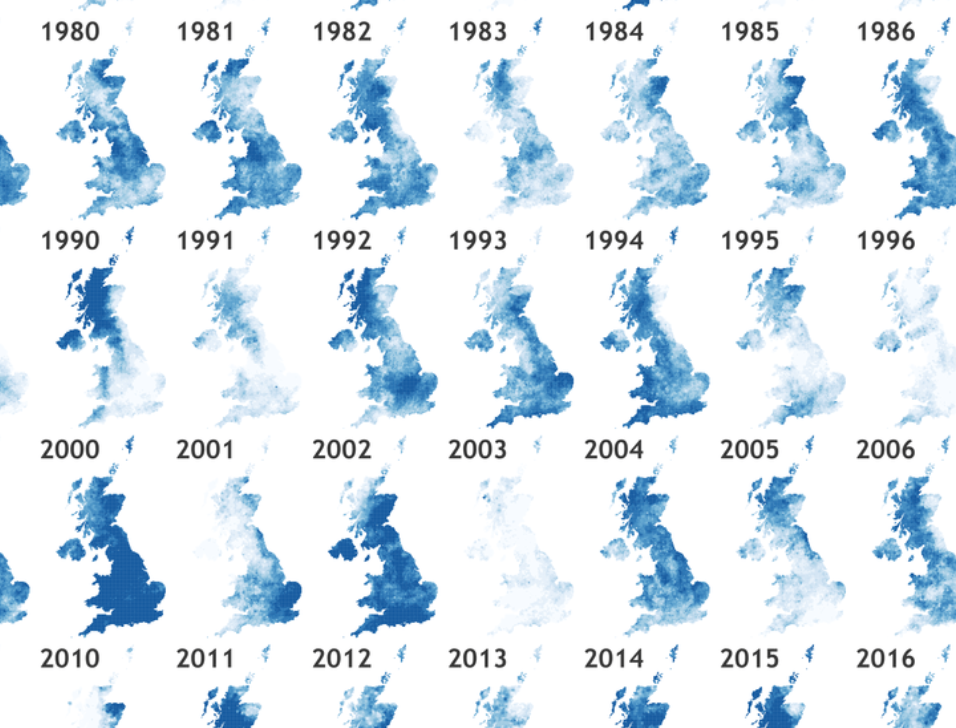
